# RF

In [ ]:
  from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

data_folder = '/content/drive/MyDrive/2months_data'
all_files = os.listdir(data_folder)
csv_files = [os.path.join(data_folder, f) for f in all_files if f.endswith('.csv')]

def read_csv_file(file_path):
    encodings = ['utf-8', 'cp949', 'euc-kr']  # List of possible encodings
    for encoding in encodings:
        try:
            return pd.read_csv(file_path, encoding=encoding)
        except (UnicodeDecodeError, pd.errors.EmptyDataError, pd.errors.ParserError):
            continue
    raise ValueError(f"Could not read file {file_path} with any encoding.")

valid_dataframes = []
for file in csv_files:
    try:
        df = read_csv_file(file)
        if not df.empty:
          valid_dataframes.append(df)
    except ValueError as e:
        print(e)

if valid_dataframes:
    combined_data = pd.concat(valid_dataframes, ignore_index=True)
else:
    combined_data = pd.DataFrame()
combined_data.columns=["Creation date", "load factor", "Set Pressure", "Boiler Pressure",
                      "Blower Inverter Output", "Blower Input", "Water Supply Pump",
                      "Water Supply Pump Input", "Gas Damper", "Gas Damper Input",
                      "Air Damper", "Air Damper Input", "Recirculation Damper",
                      "Recirculation External Damper", "Recirculation Damper Input",
                      "Recirculation External Damper Input", "Water Supply Level",
                      "Boiler Temperature", "Exhaust Gas Temperature 1",
                      "Exhaust Gas Temperature 2", "Exhaust Gas Temperature 3",
                      "Exhaust Recirculation Temperature", "Economizer Temperature 1",
                      "Economizer Temperature 2", "Burner Temperature", "Exhaust Gas NOx",
                      "Exhaust Gas O2", "Recirculation O2", "Recirculation NOx",
                      "Water Supply Amount (Cumulative Flow)",
                      "Water Supply Amount (Instantaneous Flow)",
                      "Fuel Amount (Cumulative Flow)", "Fuel Amount (Instantaneous Flow)",
                      "Efficiency (Instantaneous)", "Power Consumption", "Vibration Sensor 1",
                      "Vibration Sensor 2", "Operating Time", "Normal Operation Probability",
                      "Blower Failure Probability", "Air Damper Failure Probability",
                      "Gas Damper Failure Probability", "Probability Update Time",
                      "Instantaneous Steam Amount", "Input-Output Efficiency",
                      "Heat Loss Efficiency", "Efficiency (input/output method-steam)"]
combined_data = combined_data.drop(columns=[
    "Creation date","Power Consumption","Vibration Sensor 1","Vibration Sensor 2","Operating Time",
    "Normal Operation Probability","Blower Failure Probability","Air Damper Failure Probability",
    "Gas Damper Failure Probability","Probability Update Time","Instantaneous Steam Amount",
    "Input-Output Efficiency","Heat Loss Efficiency","Efficiency (input/output method-steam)",
    "Exhaust Recirculation Temperature","Burner Temperature"
])

scaler = StandardScaler()
numeric_columns = combined_data.select_dtypes(include=['float64', 'int64']).columns
combined_data[numeric_columns] = scaler.fit_transform(combined_data[numeric_columns])

# Select numerical columns only
numerical_columns = combined_data.select_dtypes(include=['float64', 'int64']).columns

# Fill missing values in numerical columns with the mean value
combined_data[numerical_columns] = combined_data[numerical_columns].apply(lambda col: col.fillna(col.mean()))

# For categorical columns, fill missing values with the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
combined_data[combined_data.select_dtypes(include=['object']).columns] = cat_imputer.fit_transform(combined_data.select_dtypes(include=['object']))

# Encode categorical variables (if any)
label_encoder = LabelEncoder()
for column in combined_data.select_dtypes(include=['object']).columns:
    combined_data[column] = label_encoder.fit_transform(combined_data[column])

combined_data.to_csv('/content/drive/MyDrive/preprocessed_boiler_data.csv', index=False, encoding='utf-8')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
combined_data.head()

,load factor,Set Pressure,Boiler Pressure,Blower Inverter Output,Blower Input,Water Supply Pump,Water Supply Pump Input,Gas Damper,Gas Damper Input,Air Damper,...,Economizer Temperature 2,Exhaust Gas NOx,Exhaust Gas O2,Recirculation O2,Recirculation NOx,Water Supply Amount (Cumulative Flow),Water Supply Amount (Instantaneous Flow),Fuel Amount (Cumulative Flow),Fuel Amount (Instantaneous Flow),Efficiency (Instantaneous)
0,3.286260e-14,1.491559,0.664761,0.654283,-0.582379,0.0,0.145827,0.123496,0.251636,0.280633,...,0,-1.152654,0.0,0.0,0.848154,-0.586383,0.854353,0.317931,-0.076516,-0.066126
1,3.286260e-14,1.491559,0.664761,0.656992,-0.582379,0.0,0.145827,0.131905,0.251636,0.280633,...,0,-1.152654,0.0,0.0,0.848154,-0.586383,0.854353,0.316239,-0.076516,-0.064171
2,3.286260e-14,1.491559,0.506064,0.654283,-0.582379,0.0,-0.061960,0.136109,0.056916,0.284692,...,0,-1.152654,0.0,0.0,0.848154,-0.586383,0.854353,0.314547,-0.076516,0.023791
3,3.286260e-14,1.491559,0.506064,0.610944,-0.582379,0.0,-0.061960,0.131905,0.056916,0.276573,...,0,-1.152654,0.0,0.0,0.848154,-0.586383,0.854353,0.307781,-0.076516,-0.057330
4,3.286260e-14,1.491559,0.506064,0.556770,-0.582379,0.0,-0.061960,-0.061491,0.056916,0.203498,...,0,-1.152654,0.0,0.0,0.848154,-0.586383,0.854353,0.290866,-0.076516,-0.148713


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import randint

# combined_data = 전처리된 데이터프레임 (전처리 코드는 이미 실행된 상태라고 가정)

# 독립 변수(X)와 종속 변수(y) 설정
X = combined_data.drop(columns=['Efficiency (Instantaneous)'])  # 종속 변수 제외
y = combined_data['Efficiency (Instantaneous)']

# 데이터 분할: 훈련 데이터와 테스트 데이터로 분할
# 여기에서 train_test_split을 사용하여 X_train, X_test, y_train, y_test를 생성
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 예시: 80% 훈련, 20% 테스트

# Random Forest Model with RandomizedSearchCV for hyperparameter tuning
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_distributions = {
    'n_estimators': [50, 100, 200],      # Number of trees
    'max_depth': [None, 10, 15, 20, 25],           # Maximum depth of the tree
    'min_samples_split': [2,5,10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1,2,4],    # Minimum number of samples required to be at a leaf node
    'max_features':['sqrt', 'log2'],  # Number of features to consider at each split
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2]  # 리프 노드의 가중치 샘플 최소값
}

# Randomized Search CV with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                   n_iter=50, cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters
print("Best hyperparameters found by RandomizedSearchCV:")
print(random_search.best_params_)

# Model evaluation using test data
y_pred = random_search.predict(X_test)

# Calculate performance metrics
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
mse = np.mean((y_test - y_pred) ** 2)

print(f"MAPE: {mape:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters found by RandomizedSearchCV:
{'n_estimators': 50, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25}
MAPE: 7.8843
MAE: 0.0207
RMSE: 0.0475
MSE: 0.0023


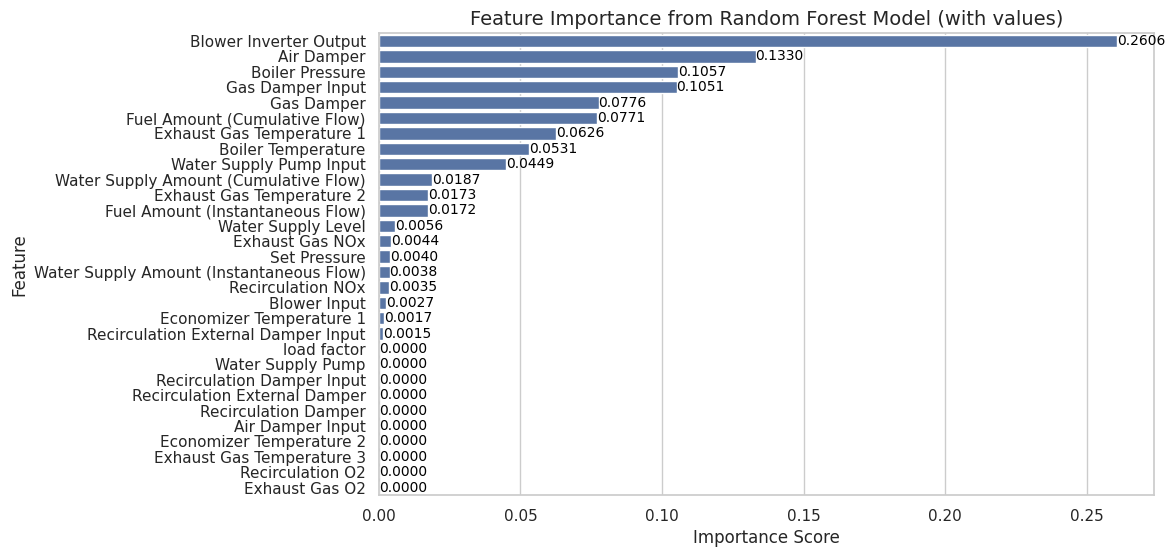

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.font_manager as fm
import shutil

# Seaborn 스타일 적용
sns.set(style="whitegrid")

# 예시 데이터 (random_search.best_estimator_는 미리 학습된 상태여야 함)
feature_importances = random_search.best_estimator_.feature_importances_
features = X.columns  # 각 피처의 이름

# 피처 중요도를 시리즈로 변환하고, 중요도 순서대로 정렬
feature_importance_series = pd.Series(feature_importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=feature_importance_series, y=feature_importance_series.index)

# 각 바에 중요도 값을 텍스트로 표시
for i, (value, name) in enumerate(zip(feature_importance_series, feature_importance_series.index)):
    ax.text(value, i, f'{value:.4f}', va='center', ha='left', fontsize=10, color='black')

plt.title('Feature Importance from Random Forest Model (with values)', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

# GA에 사용할 RF - importance score 0.001 이상

MAPE (Filtered): 7.6359
MAE (Filtered): 0.0201
RMSE (Filtered): 0.0466
MSE (Filtered): 0.0022


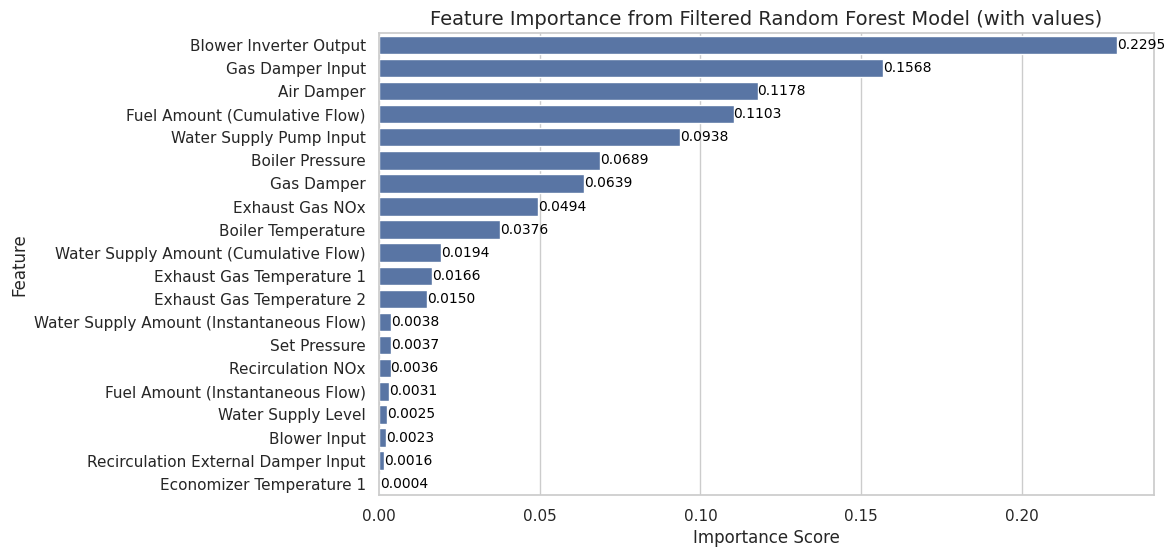

In [ ]:
# Step 1: Random Search에서 찾은 최적의 하이퍼파라미터를 적용한 새로운 Random Forest 모델 학습
best_params = random_search.best_params_  # 이전 RandomizedSearchCV에서 찾은 최적의 하이퍼파라미터

# Feature Importance가 0.001 이상인 피처들만 선택
importance_threshold = 0.001
important_features = feature_importance_series[feature_importance_series > importance_threshold].index
X_filtered = X[important_features]  # 중요도가 0.001 이상인 피처들만 사용

# 데이터 분할: 훈련 데이터와 테스트 데이터로 다시 분할
X_train_filtered, X_test_filtered, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

# 새로운 Random Forest 모델 생성 (최적 하이퍼파라미터 사용)
rf_filtered = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    min_weight_fraction_leaf=best_params['min_weight_fraction_leaf'],
    random_state=42
)

# 모델 학습
rf_filtered.fit(X_train_filtered, y_train)

# Step 2: 모델 평가
y_pred_filtered = rf_filtered.predict(X_test_filtered)

# 성능 지표 계산
mape_filtered = np.mean(np.abs((y_test - y_pred_filtered) / y_test)) * 100
mae_filtered = np.mean(np.abs(y_test - y_pred_filtered))
rmse_filtered = np.sqrt(np.mean((y_test - y_pred_filtered) ** 2))
mse_filtered = np.mean((y_test - y_pred_filtered) ** 2)

print(f"MAPE (Filtered): {mape_filtered:.4f}")
print(f"MAE (Filtered): {mae_filtered:.4f}")
print(f"RMSE (Filtered): {rmse_filtered:.4f}")
print(f"MSE (Filtered): {mse_filtered:.4f}")

# Step 3: Feature Importance 시각화 (필터링된 피처만)
feature_importances_filtered = rf_filtered.feature_importances_

# 피처 중요도 시리즈로 변환하고 중요도 순서대로 정렬
feature_importance_series_filtered = pd.Series(feature_importances_filtered, index=important_features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=feature_importance_series_filtered, y=feature_importance_series_filtered.index)

# 각 바에 중요도 값을 텍스트로 표시
for i, (value, name) in enumerate(zip(feature_importance_series_filtered, feature_importance_series_filtered.index)):
    ax.text(value, i, f'{value:.4f}', va='center', ha='left', fontsize=10, color='black')

plt.title('Feature Importance from Filtered Random Forest Model (with values)', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()


# GA

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import random
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Step 1: 목표 손실 함수 정의 (손실 함수로 사용될 성능 지표 정의)
def rf_loss_function(individual):
    # 개체의 하이퍼파라미터를 기반으로 모델 생성
    n_estimators = int(individual[0])
    max_depth = int(individual[1]) if individual[1] != None else None
    min_samples_split = int(individual[2])
    min_samples_leaf = int(individual[3])
    max_features = individual[4]
    min_weight_fraction_leaf = individual[5]

    # 필터링된 데이터로 모델 학습
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        random_state=42
    )

    # 교차 검증을 통해 모델의 성능 평가 (예: MSE)
    scores = cross_val_score(model, X_train_filtered, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    mse = -np.mean(scores)  # MSE 값이 음수이므로 양수로 변환

    return mse,  # 튜플로 반환

# Step 2: 유전 알고리즘 설정
# GA는 개체(Individual)를 생성하여 하이퍼파라미터를 탐색합니다.

# DEAP 설정
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # 최소화를 목표로 설정 (손실 최소화)
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# 하이퍼파라미터 범위 정의 (유전 알고리즘에서 사용할 범위)
toolbox.register("n_estimators", random.randint, 50, 200)  # n_estimators 범위
toolbox.register("max_depth", random.randint, 10, 25)  # max_depth 범위
toolbox.register("min_samples_split", random.randint, 2, 10)  # min_samples_split 범위
toolbox.register("min_samples_leaf", random.randint, 1, 4)  # min_samples_leaf 범위
toolbox.register("max_features", random.choice, ['sqrt', 'log2'])  # max_features 범위 (문자열)
toolbox.register("min_weight_fraction_leaf", random.uniform, 0.0, 0.5)  # min_weight_fraction_leaf 범위 (0.0에서 0.5 사이로 제한)

# 개체(하이퍼파라미터 세트) 생성
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.n_estimators, toolbox.max_depth, toolbox.min_samples_split,
                  toolbox.min_samples_leaf, toolbox.max_features, toolbox.min_weight_fraction_leaf))

# 군집(집단) 생성
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 평가 함수로 손실 함수 설정
toolbox.register("evaluate", rf_loss_function)

# 유전 알고리즘 연산 정의 (교배, 변이, 선택)

# 변이 연산 - 숫자형 파라미터에 대해 Gaussian 변이를 적용하고, 문자열 파라미터는 교체 방식 사용
def custom_mutation(individual):
    # 숫자형 하이퍼파라미터에 대한 변이
    for i in range(len(individual)):
        if isinstance(individual[i], (int, float)):
            if random.random() < 0.2:  # 변이 확률
                individual[i] += random.gauss(0, 1)
                # n_estimators와 같은 값은 1 이상, min_weight_fraction_leaf는 0.0~0.5 범위로 제한
                if i == 0:  # n_estimators
                    individual[i] = max(1, individual[i])  # 1 이상 유지
                elif i == 5:  # min_weight_fraction_leaf
                    individual[i] = max(0.0, min(0.5, individual[i]))  # 0.0~0.5 사이로 제한
        # 문자열 하이퍼파라미터에 대한 변이 (ex: max_features)
        elif isinstance(individual[i], str):
            if random.random() < 0.2:  # 변이 확률
                individual[i] = random.choice(['sqrt', 'log2'])  # 선택 교체
    return individual,

toolbox.register("mate", tools.cxUniform, indpb=0.5)  # 교배 연산
toolbox.register("mutate", custom_mutation)  # 사용자 정의 변이 연산
toolbox.register("select", tools.selTournament, tournsize=3)  # 선택 연산

# Step 3: 유전 알고리즘 실행
def run_ga():
    # 초기 집단 생성
    population = toolbox.population(n=20)

    # 유전자 알고리즘 실행 (세대 수, 교배/변이 확률 설정)
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=30, verbose=True)

    # 최적의 개체 찾기
    best_individual = tools.selBest(population, k=1)[0]
    print("Best individual (optimized hyperparameters):", best_individual)
    return best_individual

# GA 실행
best_hyperparameters = run_ga()

# Step 4: 최적화된 하이퍼파라미터로 최종 Random Forest 모델 학습
rf_optimized = RandomForestRegressor(
    n_estimators=int(best_hyperparameters[0]),
    max_depth=int(best_hyperparameters[1]) if best_hyperparameters[1] != None else None,
    min_samples_split=int(best_hyperparameters[2]),
    min_samples_leaf=int(best_hyperparameters[3]),
    max_features=best_hyperparameters[4],
    min_weight_fraction_leaf=best_hyperparameters[5],
    random_state=42
)

rf_optimized.fit(X_train_filtered, y_train)

# 최종 모델 평가
y_pred_ga = rf_optimized.predict(X_test_filtered)

# 성능 지표 계산
mape_ga = np.mean(np.abs((y_test - y_pred_ga) / y_test)) * 100
mae_ga = np.mean(np.abs(y_test - y_pred_ga))
rmse_ga = np.sqrt(np.mean((y_test - y_pred_ga) ** 2))
mse_ga = np.mean((y_test - y_pred_ga) ** 2)

print(f"MAPE (GA Optimized): {mape_ga:.4f}")
print(f"MAE (GA Optimized): {mae_ga:.4f}")
print(f"RMSE (GA Optimized): {rmse_ga:.4f}")
print(f"MSE (GA Optimized): {mse_ga:.4f}")


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	20    
1  	15    
2  	10    


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_weight_fraction_leaf' parameter of RandomForestRegressor must be a float in the range [0.0, 0.5]. Got 1.102993242327128 instead.
